In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
import cv2
import random
from tqdm import tqdm

In [2]:
img1 = cv2.imread("img1.png")
img2 = cv2.imread("img2.png")
img3 = cv2.imread("img3.png")

In [3]:
img1.shape

(360, 640, 3)

### Given Images:

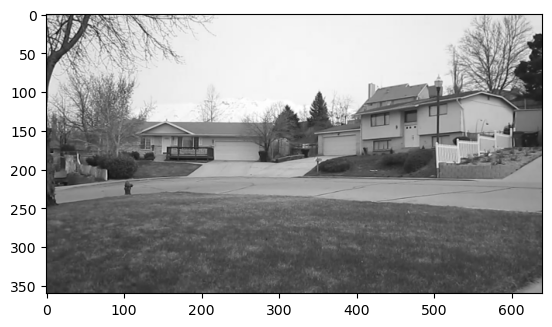

In [4]:
plt.imshow(img1,cmap="gray");

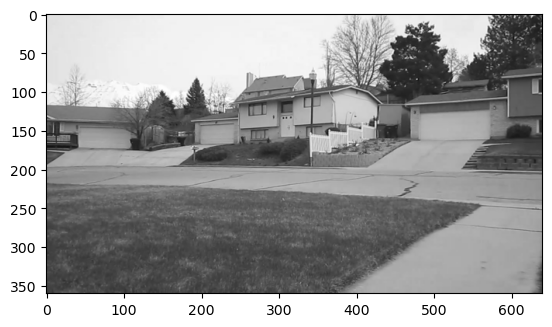

In [5]:
plt.imshow(img2,cmap="gray");

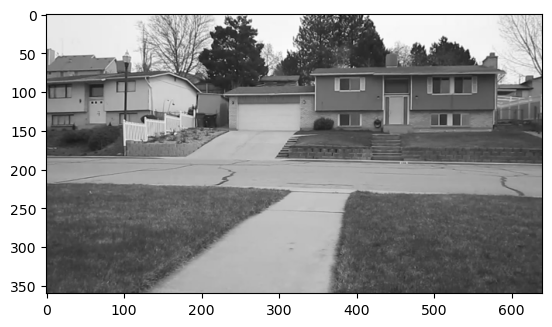

In [6]:
plt.imshow(img3,cmap="gray");

### Finding Point Correspondance

In [7]:
from sift import sift as sift_corresp
[corresp1, corresp21] = sift_corresp(img1,img2)
[corresp22, corresp3] = sift_corresp(img2,img3)

In [8]:
len(corresp1),len(corresp21)

(314, 314)

$\begin{bmatrix} x' \\ y' \\ z'\end{bmatrix}$ = $\begin{bmatrix} h1 & h2 & h3 \\ h4 & h5 & h6 \\ h7 & h8 & h9 \end{bmatrix}$$\begin{bmatrix} x \\ y \\1\end{bmatrix}$

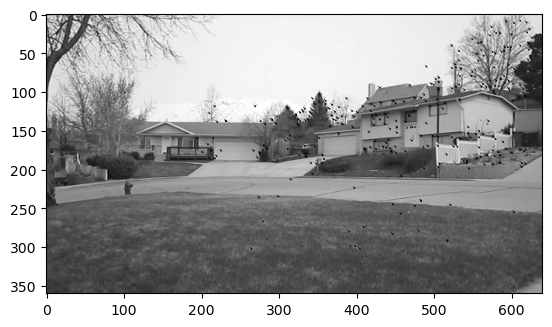

In [12]:
img_cpy = img1.copy()
for pt in corresp1:
    img_cpy[int(pt[0])-1][int(pt[1])-1] = 0
    img_cpy[int(pt[0])][int(pt[1])] = 0
    img_cpy[int(pt[0])+1][int(pt[1])] = 0
    img_cpy[int(pt[0])][1+int(pt[1])] = 0
    img_cpy[int(pt[0])+1][1+int(pt[1])] = 0
plt.imshow(img_cpy,cmap="gray");

$(x)h1 + (y)h2 + (1)h3 + (0)h4 + (0)h5 + (0)h6
− (x
′x)h7 − (x
′
y)h8 − (x
′
)h9 = 0$ <br>
$(0)h1 + (0)h2 + (0)h3 + (x)h4 + (y)h5 + (1)h6
− (y
′x)h7 − (y
′
y)h8 − (y
′
)h9 = 0$

$\begin{bmatrix} 
x_1 & y_1& 1 & 0 & 0 & 0 & -x_1'x_1 & -x_1'y_1 & -x_1' \\
0 & 0 & 0 & x_1 & y_1& 1 & -y_1'x_1 & -y_1'y_1 & -y_1' \\
x_2 & y_2& 1 & 0 & 0 & 0 & -x_2'x_2 & -x_2'y_2 & -x_2' \\
0 & 0 & 0 & x_2 & y_2& 1 & -y_2'x_2 & -y_2'y_2 & -y_2' \\
x_3 & y_3& 1 & 0 & 0 & 0 & -x_3'x_3 & -x_3'y_3 & -x_3' \\
0 & 0 & 0 & x_3 & y_3& 1 & -y_3'x_3 & -y_3'y_3 & -y_3' \\
x_4 & y_4& 1 & 0 & 0 & 0 & -x_4'x_4 & -x_4'y_4 & -x_4' \\
0 & 0 & 0 & x_4 & y_4& 1 & -y_4'x_4 & -y_4'y_4 & -y_4' \\
\end{bmatrix}$ $\begin{bmatrix} 
h1\\ h2\\h3 \\h4\\h5\\h6\\h7\\h8\\h9
\end{bmatrix}$ =  $\begin{bmatrix} 
0\\ 0\\0 \\0\\0\\0\\0\\0\\0
\end{bmatrix}$ <br>
$Ah=0$<br>
$h$ is the eigen-vector corresponding to the lowest eigen-value<br>
Reshaping h into 3x3 gives Homography Matrix(H) <br>
With the help of H we can map the points between the two images<br>
i.e. $I_1$ = $H_{21}$$I_2$

## Homography Matrix

In [9]:
def find_homography_matrix(corsp1,corsp2,threashold,iterations): 
    img1_points = corsp1
    img2_points = corsp2
    H_mats = []
    count_list = []
    for it in range(iterations):
        pts_index = np.random.choice(len(img1_points),4)
        chosen_4pts_img1 = []
        chosen_4pts_img2 = []
        for pts in range(4):
            chosen_4pts_img1.append(list(img1_points[pts_index[pts]]))
            chosen_4pts_img2.append(list(img2_points[pts_index[pts]]))
        #print(chosen_4pts_img1,chosen_4pts_img2)
        A = []
        b = []
        for pts1 in range(4):
            xt,yt = chosen_4pts_img1[pts1]
            xs,ys = chosen_4pts_img2[pts1]
            A.append([xs,ys,1,0,0,0,-xs*xt,-ys*xt, -xt])
            A.append([0,0,0,xs,ys,1,-xs*yt,-ys*yt, -yt])
        U,s,V = np.linalg.svd(A)
        h = V[-1]/V[-1,-1] #np.linalg.lstsq(A,b)[0]#
        #h = np.concatenate((h,[1]),axis=-1)
        H = h.reshape(3,3)
        count = 0
        for pts2 in range(len(img1_points)):
            X_pr = np.array(H)@np.array([img2_points[pts2][0],img2_points[pts2][1],1]).T
            err = np.sqrt((X_pr[0]/X_pr[2]-img1_points[pts2][0])**2+(X_pr[1]/X_pr[2]-img1_points[pts2][1])**2)
            if err<=threashold:
                count = count+1
        if count>=0.8*len(img1_points):
            count_list.append(count)
            H_mats.append(H)
            #print([chosen_4pts_img2[pts2][0],chosen_4pts_img2[pts2][1],1])
    H_final = H_mats[np.argmax(count_list)]
    return H_final            

In [10]:
H21 = find_homography_matrix(corresp1,corresp21,10,200)
H21

array([[ 9.46728648e-01, -7.13526252e-02,  2.81362462e+01],
       [ 4.04622275e-02,  7.98018136e-01,  1.76240202e+02],
       [ 5.15039459e-05, -3.20035105e-04,  1.00000000e+00]])

In [11]:
H23 = find_homography_matrix(corresp3,corresp22,10,200)
H23

array([[ 1.48434627e+00,  1.99229509e-01, -1.09353208e+02],
       [ 5.67199736e-03,  1.68497144e+00, -4.37952329e+02],
       [ 8.12578099e-05,  1.05227100e-03,  1.00000000e+00]])

## Bilinear Interpolation

In [12]:
def interpolate(img_2,xs,ys):
    if (xs>=0 and xs<img_2.shape[0] and ys>=0 and ys<img_2.shape[1]):
                a = xs - int(xs) 
                b = ys - int(ys)
                
                x_left = int(xs)
                if(x_left<img_2.shape[0]-1):
                    x_right = int(xs) +1
                else:
                    x_right = x_left
                y_top = int(ys)
                if(y_top<img_2.shape[1]-1):
                    y_bottom = y_top +1
                else:
                    y_bottom = y_top
                return (1-a)*(1-b)*img_2[x_left][y_top]+ a*(1-b)*img_2[x_right][y_top]+ (1-a)*b*img_2[x_left][y_bottom]+ a*b*img_2[x_right][y_bottom]
    else:
        return 0

## Mosaicing

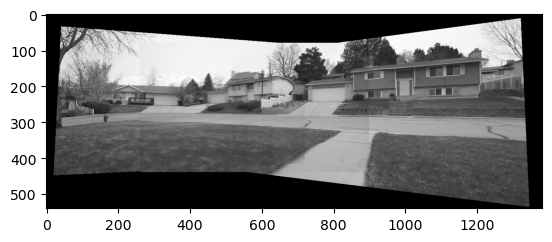

In [13]:
# Finding Columns
P1_org = np.linalg.inv(H21)@np.array([0,0,1])
P3_org = np.linalg.inv(H23)@np.array([img3.shape[0]-1,img3.shape[1]-1,1])
tcols = int(np.abs(P1_org[1]/P1_org[2]))+int(np.abs(P3_org[1]/P3_org[2]))+80
Final_img = np.zeros([len(img1)+180,tcols])#+len(img2[0])+70])
# Mosaicing
rc =80
cc = 260
for row in range(len(Final_img)):
    for col in range(len(Final_img[0])):
        #if(row-100>
        P21 = np.array([row-rc,col-cc,1]).T
        P1_est = H21@P21
        count =0
        if(P1_est[0]/P1_est[2]>=0 and P1_est[0]/P1_est[2]<len(img1) and P1_est[1]/P1_est[2]>=0 and P1_est[1]/P1_est[2]<len(img1[0])):
            count = count+1
            Final_img[row][col] = interpolate(img1[:,:,0],P1_est[0]/P1_est[2],P1_est[1]/P1_est[2])
            #img1[int(P1_est[0]/P1_est[2])][int(P1_est[1]/P1_est[2])][0]
        if(row-rc>=0 and row-rc<len(img2) and col-cc>0 and col-cc<len(img2[0])):
            count = count+1
            Final_img[row][col] = Final_img[row][col]+interpolate(img2[:,:,0],row-rc,col-cc)
            #Final_img[row][col]+img2[row-rc][col-cc][0]
        P23 = np.array([row-rc,col-cc,1]).T
        P3_est = H23@P23
        if(P3_est[0]/P3_est[2]>=0 and P3_est[0]/P3_est[2]<len(img3) and P3_est[1]/P3_est[2]>=0 and P3_est[1]/P3_est[2]<len(img3[0])):
            count = count+1
            Final_img[row][col] = Final_img[row][col]+interpolate(img3[:,:,0],P3_est[0]/P3_est[2],P3_est[1]/P3_est[2])
            #Final_img[row][col]+img3[int(P3_est[0]/P3_est[2])][int(P3_est[1]/P3_est[2])][0]
        if(count>0):
            Final_img[row][col] =  Final_img[row][col]/count
        
plt.imshow(Final_img,cmap='gray') 

## Automatic Mosaicing for Multiple Images

In [14]:
def mosaic(imgs):
    H = []
    threashold=10
    iterations = 200
    for i in range(len(imgs)-1):
        [correspi, correspi1] = sift_corresp(imgs[i],imgs[i+1])
        H.append(find_homography_matrix(correspi1,correspi,threashold,iterations))
    H_fl = np.identity(3,dtype=float)
    for i in range(len(H)):
        H_fl = H_fl@H[i]
    num = len(imgs)
    trows = np.linalg.inv(H_fl)@np.array([0,imgs[num-1].shape[1]-1,1]).T    
    tcols = np.linalg.inv(H_fl)@np.array([imgs[num-1].shape[0]-1,imgs[num-1].shape[1]-1,1]).T
    total_rows = int(np.abs(trows[0]/trows[2])+int(tcols[0]/tcols[2]))+20
    rc=total_rows//2-imgs[0].shape[0]//2
    Final_img = np.zeros([total_rows+100,int(tcols[1]/tcols[2])+20])
    for row in tqdm(range(len(Final_img))):
        for col in range(len(Final_img[0])):
            count = 0
            H_mat = np.identity(3,dtype=float)
            for i in range(len(imgs)):
                P1_est = H_mat@np.array([row-rc,col,1]).T
                if(P1_est[0]/P1_est[2]>=0 and P1_est[0]/P1_est[2]<len(imgs[i]) and P1_est[1]/P1_est[2]>=0 and P1_est[1]/P1_est[2]<len(imgs[i][0])):
                    count = count+1
                    Final_img[row][col] = Final_img[row][col]+interpolate(imgs[i],P1_est[0]/P1_est[2],P1_est[1]/P1_est[2])
                if(i<len(H)):
                    H_mat = H_mat@H[i]
            if(count>0):
                Final_img[row][col] =  Final_img[row][col]/count
    return Final_img

100%|██████████| 925/925 [00:42<00:00, 21.75it/s]


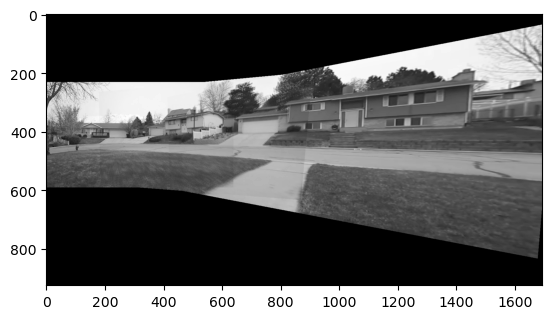

In [15]:
imgs = [img1[:,:,0],img2[:,:,0],img3[:,:,0]]
fimg = mosaic(imgs)
plt.imshow(fimg,cmap='gray')

## Mosaicing on Own Images

In [16]:
def Mosaic_3imgs(img1,img2,img3):
    [corresp1, corresp21] = sift_corresp(img1,img2)
    [corresp22, corresp3] = sift_corresp(img2,img3)
    H21 = find_homography_matrix(corresp1,corresp21,10,200)
    H23 = find_homography_matrix(corresp3,corresp22,10,200)
    # Finding Columns
    P1_org = np.linalg.inv(H21)@np.array([0,0,1])
    P3_org = np.linalg.inv(H23)@np.array([img3.shape[0]-1,img3.shape[1]-1,1])
    tcols = int(np.abs(P1_org[1]/P1_org[2]))+int(np.abs(P3_org[1]/P3_org[2]))+30
    Final_img = np.zeros([int(P3_org[0]/P3_org[2]-P1_org[0]/P1_org[2])+180,tcols+500])#+len(img2[0])+70])
    # Mosaicing
    rc =len(img2[0])//2
    cc = int(np.abs(P1_org[1]/P1_org[2]))+300
    for row in tqdm(range(len(Final_img))):
        for col in range(len(Final_img[0])):
            #if(row-100>
            P21 = np.array([row-rc,col-cc,1]).T
            P1_est = H21@P21
            count =0
            if(P1_est[0]/P1_est[2]>=0 and P1_est[0]/P1_est[2]<len(img1) and P1_est[1]/P1_est[2]>=0 and P1_est[1]/P1_est[2]<len(img1[0])):
                count = count+1
                Final_img[row][col] = interpolate(img1,P1_est[0]/P1_est[2],P1_est[1]/P1_est[2])
                #img1[int(P1_est[0]/P1_est[2])][int(P1_est[1]/P1_est[2])][0]
            if(row-rc>=0 and row-rc<len(img2) and col-cc>0 and col-cc<len(img2[0])):
                count = count+1
                Final_img[row][col] = Final_img[row][col]+interpolate(img2,row-rc,col-cc)
                #Final_img[row][col]+img2[row-rc][col-cc][0]
            P23 = np.array([row-rc,col-cc,1]).T
            P3_est = H23@P23
            if(P3_est[0]/P3_est[2]>=0 and P3_est[0]/P3_est[2]<len(img3) and P3_est[1]/P3_est[2]>=0 and P3_est[1]/P3_est[2]<len(img3[0])):
                count = count+1
                Final_img[row][col] = Final_img[row][col]+interpolate(img3,P3_est[0]/P3_est[2],P3_est[1]/P3_est[2])
                #Final_img[row][col]+img3[int(P3_est[0]/P3_est[2])][int(P3_est[1]/P3_est[2])][0]
            if(count>0):
                Final_img[row][col] =  Final_img[row][col]/count
    return Final_img
            


### Mandakini

In [17]:
img1 = cv2.imread("Folder2/img1.jpg")
img2 = cv2.imread("Folder2/img2.jpg")
img3 = cv2.imread("Folder2/img3.jpg")

In [18]:
img1.shape

(4000, 3000, 3)

In [19]:
img1 = cv2.resize(img1, (600,800))
img2 = cv2.resize(img2, (600,800))
img3 = cv2.resize(img3, (600,800))
img1.shape

(800, 600, 3)

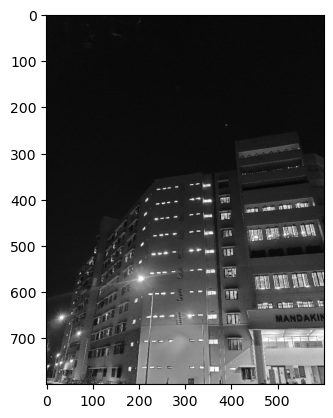

In [20]:
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
plt.imshow(img1,cmap="gray");

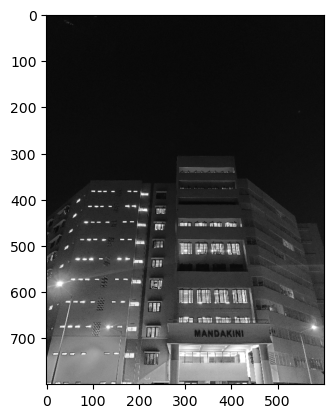

In [21]:
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
plt.imshow(img2,cmap="gray");

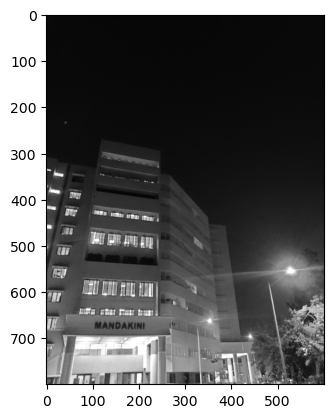

In [22]:
img3 = cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY)
plt.imshow(img3,cmap="gray");

100%|██████████| 1122/1122 [00:28<00:00, 39.64it/s]


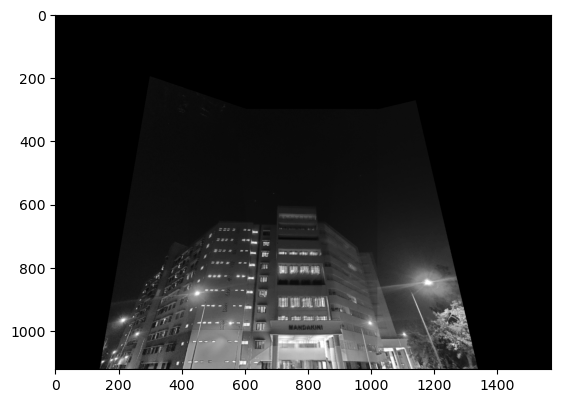

In [23]:
Final_img = Mosaic_3imgs(img1,img2,img3)
plt.imshow(Final_img,cmap='gray');

In [24]:
'''imgs = [img1,img2,img3]
fimg = mosaic(imgs)
plt.imshow(fimg,cmap='gray')'''

"imgs = [img1,img2,img3]\nfimg = mosaic(imgs)\nplt.imshow(fimg,cmap='gray')"

### Hockey Ground

In [25]:
img1 = cv2.imread("Folder1/img1.jpg")
img2 = cv2.imread("Folder1/img2.jpg")
img3 = cv2.imread("Folder1/img3.jpg")
img1 = cv2.resize(img1, (600,800))
img2 = cv2.resize(img2, (600,800))
img3 = cv2.resize(img3, (600,800))

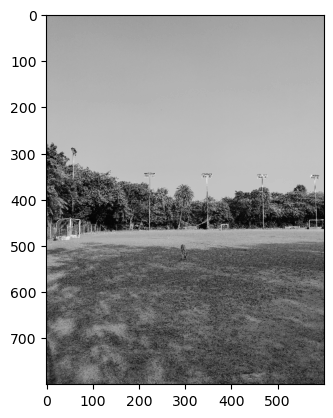

In [26]:
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
plt.imshow(img1,cmap="gray");

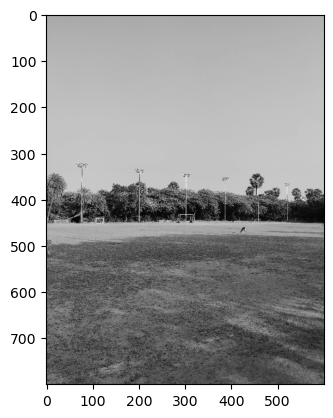

In [27]:
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
plt.imshow(img2,cmap="gray");

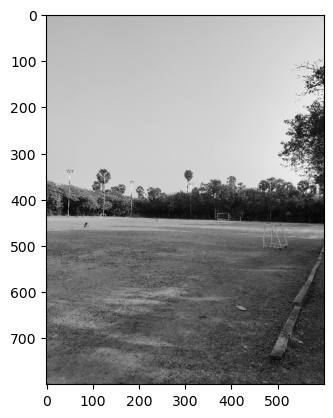

In [28]:
img3 = cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY)
plt.imshow(img3,cmap="gray");

100%|██████████| 1510/1510 [00:45<00:00, 32.85it/s]


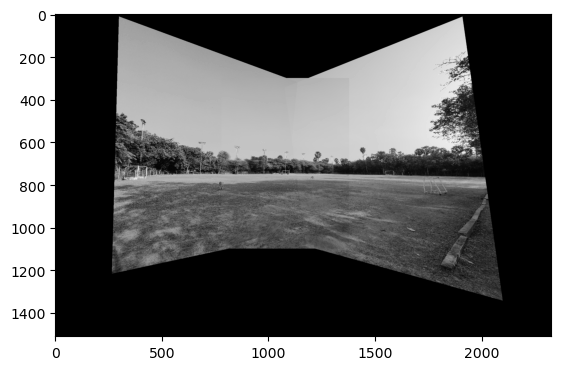

In [29]:
Final_img = Mosaic_3imgs(img1,img2,img3)
plt.imshow(Final_img,cmap='gray');